# Análisis de Garantías Crediticias

1. Carga de datos desde `garantias_dataset_final.csv`  
2. Construcción de grafo dirigido y no dirigido (con agregación de pesos)  
3. Cálculo de métricas globales (densidad, grado medio, componentes)  
4. Cálculo de centralidades (betweenness y strength)  
5. Conteo y comparación de triángulos y cliques (no dirigido vs dirigido)  
6. Cálculo del porcentaje de exposición del clique principal  
7. Link prediction: Common Neighbors, Jaccard, RandomForest + métrica (Precision, Recall, AUC)  
8. Simulación de robustez ordenada por betweenness y verificación numérica  
9. Visualizaciones:  
   - Grafo inicial  
   - Métricas de red  
   - Curvas de robustez  
   - Roles y clique destacado  
   - Heatmap Jaccard Top 10



In [65]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from networkx.algorithms.link_prediction import jaccard_coefficient
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, classification_report

# Carga de datos
df = pd.read_csv('garantias_dataset_final.csv')
print(f"Datos cargados: {len(df)} aristas")
df.head()

Datos cargados: 1652 aristas


,garante,avalado,monto_garantia
0,Empresa_C1_1,Empresa_C1_2,231932
1,Empresa_C1_1,Empresa_C1_4,237337
2,Empresa_C1_1,Empresa_C1_5,1012756
3,Empresa_C1_1,Empresa_C1_7,887201
4,Empresa_C1_1,Empresa_C1_9,203355


In [66]:
# Construcción de grafos

# Grafo dirigido
G = nx.from_pandas_edgelist(
    df,
    source='garante',
    target='avalado',
    edge_attr='monto_garantia',
    create_using=nx.DiGraph()
)


# Grafo no dirigido agregando pesos bidireccionales
UG = nx.Graph()
for u, v, d in G.edges(data=True):
    w = d['monto_garantia']
    if UG.has_edge(u, v):
        UG[u][v]['weight'] += w
    else:
        UG.add_edge(u, v, weight=w)

print(f"G → nodos: {G.number_of_nodes()}, aristas: {G.number_of_edges()}, dirigido: {G.is_directed()}")
print(f"UG → nodos: {UG.number_of_nodes()}, aristas: {UG.number_of_edges()}, dirigido: {UG.is_directed()}")


G → nodos: 120, aristas: 1652, dirigido: True
UG → nodos: 120, aristas: 1213, dirigido: False


In [67]:
# Cálculo de métricas de centralidad

# Betweenness ponderada
bet = nx.betweenness_centrality(UG, weight='weight')
# Strength: suma de pesos incidentes
strength = {n: sum(d.get('weight',1) for _,_,d in UG.edges(n, data=True)) for n in UG.nodes()}

# Crear DataFrame
df_cent = pd.DataFrame({
    'nodo': list(bet.keys()),
    'betweenness': list(bet.values()),
    'strength': [strength[n] for n in bet.keys()]
})

# Estadísticas y top-5
print('Betweenness – media:', df_cent['betweenness'].mean().round(4), 'std:', df_cent['betweenness'].std().round(4))
print('Strength – media:', int(df_cent['strength'].mean()), 'std:', int(df_cent['strength'].std()))

print('\nTop 5 betweenness:')
print(df_cent.nlargest(5, 'betweenness'))

print('\nTop 5 strength:')
print(df_cent.nlargest(5, 'strength'))

Betweenness – media: 0.0222 std: 0.0298
Strength – media: 33046128 std: 6360693

Top 5 betweenness:
             nodo  betweenness  strength
0    Empresa_C1_1     0.205954  28118279
14  Empresa_C1_20     0.123059  25564630
44  Empresa_C6_12     0.110810  40430161
15  Empresa_C3_12     0.098419  22801438
43  Empresa_C5_19     0.088022  33978068

Top 5 strength:
             nodo  betweenness  strength
51  Empresa_C3_16     0.001282  49987814
39   Empresa_C3_8     0.006837  48434335
7   Empresa_C1_11     0.039595  45358332
11  Empresa_C1_15     0.000142  43753430
21  Empresa_C1_17     0.000570  43131326


In [68]:
# Clasificar roles
roles = {}
for n in UG.nodes():
    es_g = n in df['garante'].values
    es_d = n in df['avalado'].values
    roles[n] = 'ambos' if es_g and es_d else 'garante' if es_g else 'deudor'
nx.set_node_attributes(UG, roles, 'role')
print(pd.Series(roles).value_counts())


ambos    120
Name: count, dtype: int64


In [69]:
# Comparación no dirigido vs dirigido

# Triángulos y cliques en grafo no dirigido
tri_ud = len([c for c in nx.cycle_basis(UG) if len(c) == 3])
clique_ud = len([c for c in nx.find_cliques(UG) if len(c) >= 3])

# Triángulos en grafo dirigido (ciclos de longitud 3)
tri_d = 0
for u in G.nodes():
    for v in G.successors(u):
        for w in G.successors(v):
            if G.has_edge(w, u):
                tri_d += 1
tri_d = tri_d // 3  # cada triángulo contado 3 veces

# Cliques dirigidos de tamaño >=3 (aristas recíprocas)
H = nx.Graph()
for u, v in G.edges():
    if G.has_edge(v, u):
        H.add_edge(u, v)
cliques_rec = [c for c in nx.find_cliques(H) if len(c) >= 3]
clique_d = len(cliques_rec)

# Mostrar resultados
df_tabX = pd.DataFrame({
    'Métrica': ['Triángulos', 'Cliques ≥ 3'],
    'No dirigido': [tri_ud, clique_ud],
    'Dirigido': [tri_d, clique_d]
})
df_tabX

,Métrica,No dirigido,Dirigido
0,Triángulos,786,3261
1,Cliques ≥ 3,660,220


In [70]:
# Identificación de clique principal y cálculo de exposición

# Tomar el clique más grande en UG
top_clique = sorted(nx.find_cliques(UG), key=len, reverse=True)[0]

total = df['monto_garantia'].sum()
exposure = df[
    df['garante'].isin(top_clique) &
    df['avalado'].isin(top_clique)
]['monto_garantia'].sum()
pct = exposure / total * 100
print(f'Porcentaje de exposición en el clique más grande: {pct:.2f}%')


Porcentaje de exposición en el clique más grande: 6.05%


(-0.9723830448814756,
 0.6806940106862159,
 -0.906986137943208,
 1.1812068275873637)

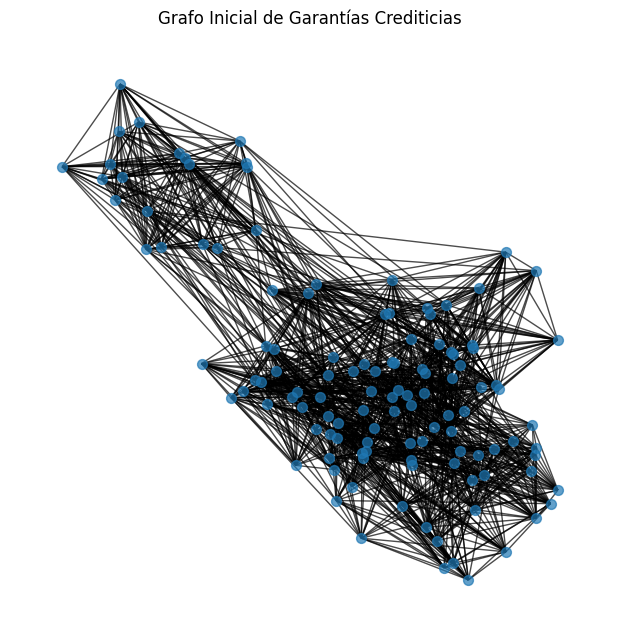

In [71]:
# Grafo inicial (sin destacar)
pos = nx.spring_layout(UG, seed=42)
plt.figure(figsize=(6,6))
nx.draw(UG, pos, node_size=50, alpha=0.7)
plt.title("Grafo Inicial de Garantías Crediticias")
plt.axis('off')


In [72]:
# Triángulos
triangles = [c for c in nx.cycle_basis(UG) if len(c)==3]
print("Triángulos:", len(triangles))

# Cliques
cliques = [cl for cl in nx.find_cliques(UG) if len(cl)>=3]
cliques_sorted = sorted(cliques, key=len, reverse=True)
print("Cliques (>=3):", len(cliques))
print("Top 5 tamaños:", [len(c) for c in cliques_sorted[:5]])


Triángulos: 786
Cliques (>=3): 660
Top 5 tamaños: [12, 12, 12, 11, 11]


In [73]:
density = nx.density(UG)
avg_deg = sum(dict(UG.degree()).values())/UG.number_of_nodes()
components = nx.number_connected_components(UG)
print(f"Densidad: {density:.4f}")
print(f"Grado medio: {avg_deg:.2f}")
print(f"Componentes conexas: {components}")


Densidad: 0.1699
Grado medio: 20.22
Componentes conexas: 1


In [74]:
nodes = list(UG.nodes())
pairs = list(combinations(nodes,2))
y_true, cn_vals, jc_vals = [], [], []
for u,v in pairs:
    y_true.append(1 if UG.has_edge(u,v) else 0)
    cn_vals.append(len(list(nx.common_neighbors(UG,u,v))))
    jc_vals.append(next((p for _,_,p in jaccard_coefficient(UG,[(u,v)]) for _ in [0]),0))

# AUC
auc_cn = roc_auc_score(y_true, cn_vals)
auc_jc = roc_auc_score(y_true, jc_vals)

# Precision/Recall (top-k)
k = sum(y_true)
idx_cn = np.argsort(cn_vals)[-k:]
idx_jc = np.argsort(jc_vals)[-k:]
y_pred_cn = [1 if i in idx_cn else 0 for i in range(len(y_true))]
y_pred_jc = [1 if i in idx_jc else 0 for i in range(len(y_true))]
prec_cn, rec_cn = precision_score(y_true,y_pred_cn), recall_score(y_true,y_pred_cn)
prec_jc, rec_jc = precision_score(y_true,y_pred_jc), recall_score(y_true,y_pred_jc)

# ML model
X = np.column_stack([cn_vals, jc_vals]); y = np.array(y_true)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42); clf.fit(X_train,y_train)
y_pred = clf.predict(X_test); y_prob = clf.predict_proba(X_test)[:,1]
report = classification_report(y_test,y_pred,output_dict=True); auc_ml = roc_auc_score(y_test,y_prob)

# Metrics table
df_metrics = pd.DataFrame({
    'Método':['Common Neighbors','Jaccard','RandomForest (ML)'],
    'Precisión':[prec_cn,prec_jc,report['1']['precision']],
    'Recall':[rec_cn,rec_jc,report['1']['recall']],
    'AUC':[auc_cn,auc_jc,auc_ml]
})
df_metrics.style.format({'Precisión':'{:.2f}','Recall':'{:.2f}','AUC':'{:.2f}'})


,Método,Precisión,Recall,AUC
0,Common Neighbors,0.80,0.80,0.89
1,Jaccard,0.80,0.80,0.88
2,RandomForest (ML),0.85,0.77,0.91


In [75]:
# Simulación de robustez ordenada por betweenness

# Subgrafo del clique principal
subG = UG.subgraph(top_clique)
# Betweenness en el subgrafo
bet_sub = nx.betweenness_centrality(subG, weight='weight')
# Orden descendente de nodos
sorted_nodes = sorted(bet_sub, key=bet_sub.get, reverse=True)

comp_sizes = []
num_comps = []
for k in range(1, len(sorted_nodes) + 1):
    G2 = UG.copy()
    G2.remove_nodes_from(sorted_nodes[:k])
    comp_sizes.append(max(len(c) for c in nx.connected_components(G2)))
    num_comps.append(nx.number_connected_components(G2))


In [76]:
# Cálculos de verificación de robustez 
# Tamaño inicial del componente gigante (sin remociones)
initial_size = max(len(c) for c in nx.connected_components(UG))

# Tamaño tras 5 nodos removidos → índice 4 de comp_sizes
size_5  = comp_sizes[4]
perc_5  = (initial_size - size_5) / initial_size * 100

# Tamaño tras 12 nodos removidos → índice 11 de comp_sizes
size_12 = comp_sizes[11]
perc_12 = (initial_size - size_12) / initial_size * 100

print(f"Tamaño inicial componente gigante: {initial_size}")
print(f"Tras 5 remociones → {size_5} nodos (−{perc_5:.2f} %)")
print(f"Tras 12 remociones → {size_12} nodos (−{perc_12:.2f} %)")


Tamaño inicial componente gigante: 120
Tras 5 remociones → 115 nodos (−4.17 %)
Tras 12 remociones → 108 nodos (−10.00 %)


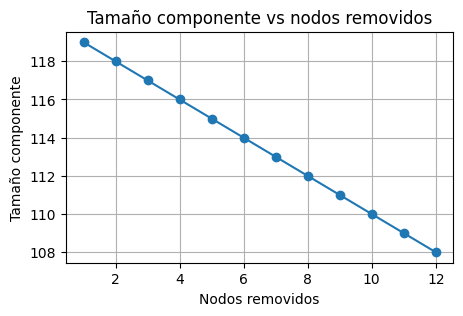

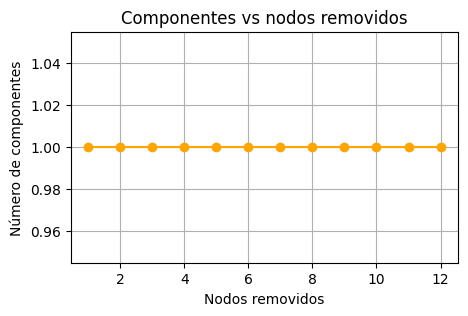

In [77]:
# Component size vs removals
plt.figure(figsize=(5,3)); plt.plot(range(1,len(sorted_nodes)+1),comp_sizes,marker='o')
plt.title("Tamaño componente vs nodos removidos"); plt.xlabel("Nodos removidos"); plt.ylabel("Tamaño componente"); plt.grid(True)

# Num components vs removals
plt.figure(figsize=(5,3)); plt.plot(range(1,len(sorted_nodes)+1),num_comps,marker='o',color='orange')
plt.title("Componentes vs nodos removidos"); plt.xlabel("Nodos removidos"); plt.ylabel("Número de componentes"); plt.grid(True)
plt.show()

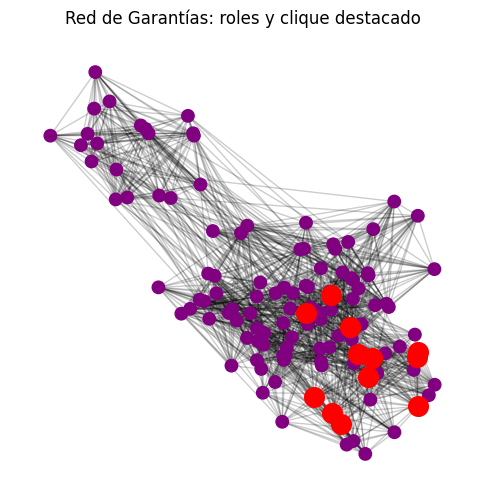

In [78]:
# Grafo roles + clique
color_map={'garante':'blue','deudor':'green','ambos':'purple'}
node_colors=[color_map[UG.nodes[n]['role']] for n in UG.nodes()]
plt.figure(figsize=(6,6)); nx.draw_networkx_edges(UG,pos,alpha=0.2)
nx.draw_networkx_nodes(UG,pos,node_color=node_colors,node_size=80)
nx.draw_networkx_nodes(UG,pos,nodelist=sorted_nodes,node_color='red',node_size=200)
plt.title("Red de Garantías: roles y clique destacado"); plt.axis('off')
plt.show()


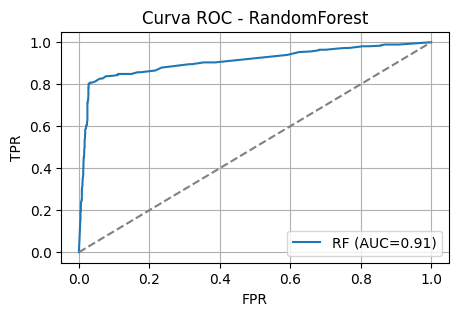

In [79]:
# ROC curve
fpr,tpr,_=roc_curve(y_test,y_prob)
plt.figure(figsize=(5,3)); plt.plot(fpr,tpr,label=f"RF (AUC={auc_ml:.2f})")
plt.plot([0,1],[0,1],'--',color='gray'); plt.title("Curva ROC - RandomForest")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True)
plt.show()

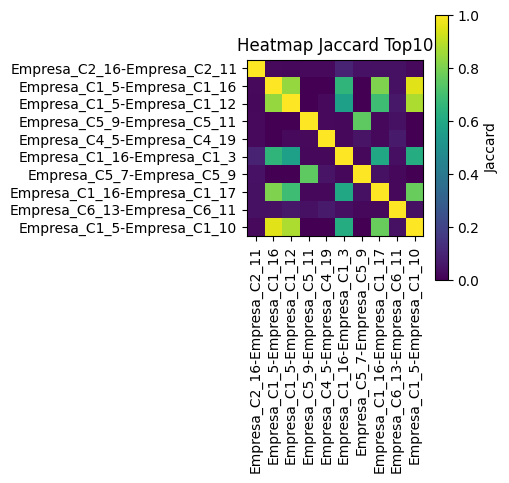

In [80]:
# Heatmap Jaccard Top10
top10 = sorted(zip(pairs, jc_vals), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{u}-{v}" for (u,v),_ in top10]
mat = np.zeros((10,10))
for i,(pair1,_) in enumerate(top10):
    neigh1 = set(UG.neighbors(pair1[0])) | set(UG.neighbors(pair1[1]))
    for j,(pair2,_) in enumerate(top10):
        neigh2 = set(UG.neighbors(pair2[0])) | set(UG.neighbors(pair2[1]))
        inter = len(neigh1 & neigh2)
        union = len(neigh1 | neigh2)
        mat[i,j] = inter/union if union>0 else 0
plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest')
plt.xticks(range(10), labels, rotation=90)
plt.yticks(range(10), labels)
plt.title("Heatmap Jaccard Top10")
plt.colorbar(label="Jaccard")
plt.tight_layout()
plt.show()


In [81]:
# Exportar resultados
df_metrics.to_csv("metrics_final.csv", index=False)
pd.DataFrame({
    'k_removed': list(range(1, len(sorted_nodes)+1)),
    'size_giant': comp_sizes,
    'num_components': num_comps
}).to_csv("robustness.csv", index=False)
print("Exportados: metrics_final.csv y robustness.csv")


Exportados: metrics_final.csv y robustness.csv
